# Supplementary material - Importance sampling example notebook

This notebook performs importance sampling on an example subset of the Monte Carlo energy cone outputs from Clarke et al. (in prep.). To run this notebook, various input files and the filing structure provided in the GitHub repository are required. This notebook requires the following files:

- input_weights.csv <-- this needs to be generated using the accompanying 'Input_weight_notebook'
- vent_opening_probabilites.csv <-- this needs to be generated using the accompanying 'Vent_opening_probabilities_notebook'
- output files from the energy cone modelling <-- a small subset of these are provided as an example
- grid_x.csv, grid_y.csv <-- UTM values of columns and rows of desired output .tiff file. Provided in 'source_files' folder 

NB. as only a small subset of the output data is provided as an example (due to online storage constraints), the results are not representative of the probabilities indicated in the Clarke et al. (in prep.) paper, and so should not be used as a PVHA.

### Features:
1. Imports output data from the Monte Carlo energy cone model
2. Uses dask to efficiently weight the model outputs based on the source vent opening probability, and weight factor ($W_k$) associated with each energy cone input parameter pair ($\phi$ and $H_0$)
3. Combines these individual processed results to produce a final 2D array showing $P(PDC|eruption)$
4. Displays the result as a simple raster
5. Georeferences the raster to a suitable UTM format, ready for import into GIS software

### Specifically, the equations for importance sampling and calculating the probability are as follows:

The probability of PDC inundation in grid cell $j$, given an eruption of vent $i$ ($P(PDC_j|vent_i)$), is calculated using the following equation:

\begin{equation}
    P(PDC_j|vent_i) = \frac{1}{S} \times \sum\limits_{k=1}^N (W_k \times s_k)
\end{equation}

where $S$ is the total number of simulations from vent $i$ (in this case, 10,000), $k$ is the identity of each simulation, and $s$ is a binary 1 or 0 within each grid cell noting inundation versus no inundation. Effectively, this counts the proportion of weighted simulations in which a PDC indundated cell $j$ from vent $i$. The final step is to also consider the probability of the eruption coming from each vent; this gives the probability of inundation in grid cell $j$ given an eruption ($P(PDC_j)$), by the following equation:    

\begin{equation}
    P(PDC_j) = \sum\limits_{i=1}^N P(PDC_j|vent_i) \times P(vent_i)
\end{equation}

where $P(vent_i)$ is the probability of vent $i$ being the source of the next eruption. This equation is applied to every grid cell, producing a map of $P(PDC|eruption)$.

### Notebook Author:
Ben Clarke <br /> 
https://github.com/GeoBen93 <br /> 
https://www.researchgate.net/profile/Ben_Clarke6 <br /> 
https://twitter.com/PyroclasticBen

### How this is done in practice:

![title](source_files/importance_sampling_overview.png)

In [1]:
import numpy as np # for array operations
import h5py # for importing .mat HDF5 files
import matplotlib.pyplot as plt # plotting
from scipy.misc import imsave, imshow # viewing as image
import pandas as pd # for importing weight data
import dask.array as da
import dask.dataframe as dd
import dask

## Step 1 - Conduct Importance sampling

This function takes each energy cone output file, consisting of results from a sinlge PDC parameter pair ($\phi$ and $H_0$) at every vent in a 3D array, and performs importance sampling. Each 3D array is in the form: (x location : y location : source vent number), stored as a compressed .hdf5 file (with a .mat alias).

The function employs 'dask' to speed up processing times, which essentially breaks the array into chunks, does the necessary calculations for each chunk in parallel, and joins the chunks back together.

The function requires:
1. inputs <-- the index of the energy cone output result to process, in this case, an integer from 1 to 10,000
2. vw     <-- a pandas dataframe of vent opening probabilities, the file: 'vent_opening_probability.csv' in 'notebook_output_files'. Generated by the 'vent_opening_probability_notebook'
3. iw     <-- a pandas dataframe of input weight factors ($W_k$), the file: 'input_weights.csv' in 'notebook_output_files'. Generated by the 'Input_weight_notebook'

What the function does:
1. Imports the result array from the energy cone model
2. Uses the einsum function to multiply each 2D slice (shape (x location : y location) ) of the 3D array, by the corresponding vent opening probability
3. Uses the einsum function to sum the 3D along the vent axis, creating a 2D array of shape (x location : y location)
4. Multiplies this 2D array by the input weight ($W_k$) associated with the paricular pair of $\phi$ and $H_0$
5. Saves the processed data as a compressed 2D array as a .hdf5 file. Found in the 'notebook_output_files/processed1_outputs' folder

In [7]:
def array_processing_stage1(inputs, vw, iw):
    ##### inputs = number of input to process(ie. 1-10,000)
    ##### vw = vent weighting in the form of pandas dataframe of vent weights for each input
    ##### iw = input weighting in the form of pandas dataframe of input weights for each input 
    ##### weightcode = number to distinguish this particular weighting procedure, must change each time different weights or methods are applied, must be a corresponding output folder
    
    ######----------IMPORT DATA--------------##########

    input_idx = inputs-1 # index of the input is 1 less than the input number as python starts counting from 0
    
    filename = 'source_files/example_results/invasion_input' + str(inputs) + '.mat'
     
    # import that file as a dask array in 1200 chunks (this appears to be fastest chunk size)
    f = h5py.File(filename)
    data = da.from_array(f["results_array"], chunks=(1200, 1305, 1305))
    
    
    ######----------PROCESSING--------#############
    
    # use the einsum function to multiply the vw with the vents and the output is the sum of vent weighted elements
    with dask.config.set(scheduler='threads'):
        collapsed = da.einsum('ijk, i -> jk', data, vw['Prob'][:1200]).compute()
    
    #apply the input weighting... because this is the same for every element of a single array, we can perform this after collapsing the array, saving processing time
    input_weight = iw['input_weight'][input_idx] # find weighting for this array according to input index
    collapsed = collapsed * input_weight # multiply the elements by this weight
        
    collapsed = collapsed.T # transpose the lat:long so they are the correct way around
    
    ######----------EXPORT-------------############
    
    #save this in a compressed HDF5 file format (about 50-100kb for 2d array shape (1305:1305))
    savefilename = 'notebook_output_files/processed1_outputs/input_' +str(inputs)+ '_p.h5'
    
    with h5py.File(savefilename, 'w') as h5f:
        h5f.create_dataset('dataset1', data=collapsed, compression='gzip', compression_opts=9)
    
    ######---------PROGRESS CHECK-------############
    
    #Create some outputs to check progress
    print('..........................')
    print('Done Input' ,inputs)

The following script runs the 'array_processing_stage1' function for the desired range of energy cone output data, saved in the 'notebook_output_files/example_results' folder. We have provided an example dataset of 20 outputs (1001 to 1019), as a test case. Each output array takes on the order of 20 seconds to process. The results are saved in the folder named 'processed1_outputs'. 

*NB. These 20 example files are not uniformly distributed in terms of $\phi$ and $H_c$ input parameters.*

To run this function, define a start_index and end_index, where each is an integer between 1001 and 1019.

In [8]:
#define start and end file indexes
start_index = 1001
end_index = 1019

#load in the input weights as a dataframe
input_filename =  'notebook_output_files/input_weights.csv' # define input weight file
iw = dd.read_csv(input_filename).compute() # load input weights into a pandas dataframe

#load in the vent opening probabilities as a dataframe
vw = dd.read_csv('notebook_output_files/vent_opening_probabilities.csv').compute()

for inputs in range(start_index, (end_index+1)):
    array_processing_stage1(inputs, vw, iw)

..........................
Done Input 1001
..........................
Done Input 1002
..........................
Done Input 1003
..........................
Done Input 1004
..........................
Done Input 1005
..........................
Done Input 1006
..........................
Done Input 1007
..........................
Done Input 1008
..........................
Done Input 1009
..........................
Done Input 1010
..........................
Done Input 1011
..........................
Done Input 1012
..........................
Done Input 1013
..........................
Done Input 1014
..........................
Done Input 1015
..........................
Done Input 1016
..........................
Done Input 1017
..........................
Done Input 1018
..........................
Done Input 1019


## Step 2 - Combine processed arrays to produce final result

The next function combines the arrays generated by the 'array_processing_stage1' into a single 2D array with the shape (x location: y location), and the value in each cell is P(PDC|eruption).

The function requires:
1. start_input <-- integer of the first array to be combined
2. end_input   <-- integer of the last array to be combined

What the function does:
1. Imports the processed1_output arrays in the defined range
2. Adds each to a new cumulative array named: 'final_result_starting_(start_input) ending (end_input).h5'
3. Divides the final array by the number of iterations
4. Saves the final result to a file named: 'final_result_starting_(start_input) ending (end_input).h5'  

In [12]:
def combine_arrays(start_input, end_input):

    def hdf5_to_array(filename):
        with h5py.File(filename) as h5f:
            f = h5py.File(filename)
            dataset_name = list(f.keys())
            result = np.array(f[dataset_name[0]])
        return result

    def array_to_hdf5(array):
        cumfilename = 'final_result_starting_' + str(start_input) + '_ending_' + str(end_input) + '.h5'
        with h5py.File(cumfilename, 'w') as h5f:
            h5f.create_dataset('dataset1', data=array, compression='gzip', compression_opts=9)
        return
    
    #initialise the cumulative array by saving the start array as the cumulative array
    start_file = 'notebook_output_files/processed1_outputs/input_' + str(start_input) + '_p.h5' 
    start_array = hdf5_to_array(start_file) #import start array
    
    cumfilename = 'notebook_output_files/final_result_starting_' + str(start_input) + '_ending_' + str(end_input) + '.h5'
    
    # load the cumulative array
    cumulative_array = start_array
    
    for file in range(start_input, end_input+1):

        # find the filename of the next array to be added to the cumulative array
        next_file = 'notebook_output_files/processed1_outputs/input_' + str(file) + '_p.h5'
        
        #import this as an array
        next_array = hdf5_to_array(next_file)

        #add the arrays together
        cumulative_array = cumulative_array + next_array

        print('........................')
        print('Added Input ' + str(file))
    
    niterations = end_input - start_input # calcualte number of iterations the result is based on 
    
    cumulative_array = cumulative_array / niterations
    cumulative_array = np.flip(cumulative_array, axis = 0) # flip the y axis so north is up (don't know why this changed...)
    array_to_hdf5(cumulative_array) #save to hdf5
    
    return cumulative_array

To run this function, simply execute the next cell. It requires the start and end indexes defined earlier. To adjust which files to combine, simply enter the start and end integer into the function arguments.

In [13]:
result = combine_arrays(start_index,end_index)

........................
Added Input 1001
........................
Added Input 1002
........................
Added Input 1003
........................
Added Input 1004
........................
Added Input 1005
........................
Added Input 1006
........................
Added Input 1007
........................
Added Input 1008
........................
Added Input 1009
........................
Added Input 1010
........................
Added Input 1011
........................
Added Input 1012
........................
Added Input 1013
........................
Added Input 1014
........................
Added Input 1015
........................
Added Input 1016
........................
Added Input 1017
........................
Added Input 1018
........................
Added Input 1019


Now lets have a quick look at what the results look like (non-georeferenced, in relative geographical space).

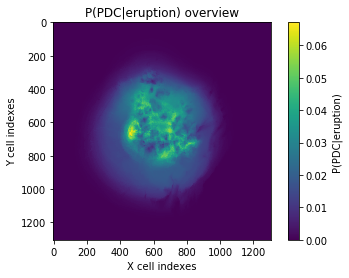

In [14]:
plt.imshow(result)
plt.title('P(PDC|eruption) overview')
plt.xlabel('X cell indexes')
plt.ylabel('Y cell indexes')
plt.colorbar(label='P(PDC|eruption)')
plt.show()

## Step 3 - Georeference the results to be viewed in GIS software

This step takes the array generated in step 2 and georeferences it, so that it can be used in GIS software as a standard raster file for map creation or analysis. This method requires a georeferenced grid to be made, which requires a list of the columns and rows (UTM coordinates) that describe the cells that form the results array generated in step 2. These are the 'grid_x.csv' and 'grid_y.csv' provided in the weighting_data folder.

The following code is adapted from https://gis.stackexchange.com/questions/37238/writing-numpy-array-to-raster-file.

What this step does:
1. Imports the x and y UTM column and row values, and creates a grid
2. Transforms this grid into a 'GeoTiff' file of the correct dimensions and resolution, with the specified EPSG coordinate system code 
3. Applies the values of the results grid from step 2 to this GeoTiff as a raster band
4. Saves the GeoTiff as: 'inundation_map.tif' in the 'notebook_output_files' folder, which is ready to import into a GIS, such as QGIS or ArcGIS

In [16]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import csv

yname = 'source_files/grid_y.csv'
xname = 'source_files/grid_x.csv'

def csv_to_float_list(filename):
    with open(filename, 'r', encoding='utf8') as f:
        reader = csv.reader(f)
        values = list(reader)

    values = values[0]
    values[0] = values[0][1:]
    for i in range(0,len(values)):
        values[i] = float(values[i])
    
    return values

lat = np.flip(np.array(csv_to_float_list(yname)))
lon = np.array(csv_to_float_list(xname))
lonG, latG = np.meshgrid(lon,lat)
array = result

xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows,ncols = np.shape(result)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)

name = 'notebook_output_files/inundation_map.tif'

output_raster = gdal.GetDriverByName('GTiff').Create(name,ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(32637)                    # This one specifies coordinate system

output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system to the file
output_raster.GetRasterBand(1).WriteArray(result)   # Writes my array to the raster

output_raster.FlushCache()